<a href="https://colab.research.google.com/github/cml096/GoogleColabRepo/blob/master/Project_Cap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [271]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [272]:
df = pd.read_excel('Rendimiento CMP V2.xlsx', sheet_name='MinaMLC')

#Preparando Data

##Filtro

In [273]:
df_ = df[df['División de personal'] == 'CMP VALLE DEL HUASCO']

In [274]:
df_test_minera_colorado = df_[df_['Subdivisión de personal'] == 'MINA LOS COLORA']

##Variables no utilizables

In [275]:
df_ = df_test_minera_colorado

In [276]:
filtro = ['División de personal',
          'Cod. División','Subdivisión de personal',
          'Cod. Subdivisión','Cod. Unidad',
          'Cod. Posición',
          'Fecha de nacimiento',
          'Fecha de alta',
          'Status empleado para Gestión tiempos per',
          'Grupo de personal',
          'Número de personal']

In [277]:
df_ = df_.drop(filtro,axis=1)

##Columna "Turno" y "Equipo"

In [278]:
df_['Turno'] = df_['Turno'].astype(str)

In [279]:
df_['Equipo'] = df_['Equipo'].astype(str)

##Divición "Fecha"

Cambiamos nombre columna "Dia" por "Fecha"

In [280]:
df_ = df_.rename(columns={'Dia':'Fecha'})

Divición de la variable "Fecha"

In [281]:
def dia(fecha):
  aux = str(fecha.date()).split('-')
  dia = str(aux[2])
  return dia

def mes(fecha):
  aux = str(fecha.date()).split('-')
  mes = str(aux[1])
  return mes

def ano(fecha):
  aux = str(fecha.date()).split('-')
  ano = str(aux[0])
  return ano

Anexamos columna "Dia", "Mes" y "Año"

In [282]:
df_['Dia'] = df_.apply(lambda row : dia(row['Fecha']),axis=1)
df_['Mes'] = df_.apply(lambda row : mes(row['Fecha']),axis=1)
df_['Año'] = df_.apply(lambda row : ano(row['Fecha']),axis=1)

##Columna "Eficiencia"

In [284]:
filtro = ['Fecha','Turno','Cargas (u)','Movimiento (t)','tdem (seg)',	'R-ef (t/h)','Edad del empleado','Equipo']
df_aux = df_.drop(filtro, axis=1)

Agrupamos por "unidad organizativa" y lo almacenamos en un data frame

In [285]:
group = df_aux.groupby(['Unidad organizativa']).max()
df_group = pd.DataFrame(group)

Creamos un array que contiene las tefe max de cada Unidad organizativa

In [286]:
def genera(data):
  lista = []
  for index, row in data.iterrows():
    lista.append([index,row['tefe (seg)']])
  return lista

In [287]:
max_por_unidad = genera(df_group)
len(max_por_unidad)

15

Agregamos la columna "Eficiencia" que generaremos con la furmula
* tefe(x tupla)*100/tefe_max

In [288]:
def rellena(data,lista):
  aux = []
  for index, row in data.iterrows():
    unidad = row['Unidad organizativa']
    tefe = row['tefe (seg)']
    for unidad_max,tefe_max in lista:
      if unidad == unidad_max:
        resultado = (tefe)/tefe_max
        aux.append(resultado)
  return aux

In [289]:
eficiencia = rellena(df_,max_por_unidad)
len(eficiencia)

1825

Le agregamos una columna al data frame

In [290]:
df_['Eficiencia'] = eficiencia

##Columna "Eficiencia (bin)" binaria

In [291]:
filtro = ['Eficiencia']
df_aux = df_.drop(filtro, axis=1)

In [292]:
group = df_aux.groupby(['Unidad organizativa']).median()
df_group = pd.DataFrame(group)

In [293]:
media_por_unidad = genera(df_group)
len(media_por_unidad)

15

In [294]:
def rellena_binario(data,lista):
  aux = []
  for index, row in data.iterrows():
    unidad = row['Unidad organizativa']
    tefe = row['tefe (seg)']
    for unidad_median,tefe_median in lista:
      if unidad == unidad_median:
        if tefe >= tefe_median:
          aux.append(1)
        elif tefe < tefe_median:
          aux.append(0)
  return aux

In [295]:
eficiencia_binaria = rellena_binario(df_,media_por_unidad)
len(eficiencia_binaria)

1825

In [296]:
df_['Eficiencia (bin)'] = eficiencia_binaria

##Data a ocupar

In [297]:
df_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1825 entries, 0 to 3137
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Fecha                1825 non-null   datetime64[ns]
 1   Turno                1825 non-null   object        
 2   Equipo               1825 non-null   object        
 3   Cargas (u)           1825 non-null   int64         
 4   Movimiento (t)       1825 non-null   float64       
 5   tefe (seg)           1825 non-null   int64         
 6   tdem (seg)           1825 non-null   int64         
 7   R-ef (t/h)           1825 non-null   float64       
 8   Unidad organizativa  1825 non-null   object        
 9   Posición             1825 non-null   object        
 10  Edad del empleado    1825 non-null   int64         
 11  Dia                  1825 non-null   object        
 12  Mes                  1825 non-null   object        
 13  Año                  1825 non-nul

In [298]:
df_.head()

,Fecha,Turno,Equipo,Cargas (u),Movimiento (t),tefe (seg),tdem (seg),R-ef (t/h),Unidad organizativa,Posición,Edad del empleado,Dia,Mes,Año,Eficiencia,Eficiencia (bin)
0,2019-07-01,2,211,93,21134.20117,21517,814,3535.954093,MANTENIMIENTO MINA,ELECTRICO III,29,01,07,2019,0.505260,0
1,2019-07-01,2,213,12,2833.59961,5593,367,1823.879599,MANTENIMIENTO MINA,MECANICO I,54,01,07,2019,0.131334,0
4,2019-07-01,2,307,100,23335.70117,35320,2801,2378.497288,ADMINISTRACION SUPTCIA PLANTAS,OPERADOR ELECTRICO II PLANTA,62,01,07,2019,0.917188,1
5,2019-07-02,1,211,148,34061.60938,37283,960,3288.946538,CAMIONES CAT 793F MLC,OPERADOR III,48,02,07,2019,0.904444,1
6,2019-07-02,1,213,7,1632.20007,2962,67,1983.767810,MANTENIMIENTO MINA,MECANICO III,33,02,07,2019,0.069553,0


#Regresión Lineal

Importamos y seleccionamos las variables que ocuparemos en el modelo

In [299]:
from sklearn.model_selection import train_test_split
X = df_[['Turno','Equipo','Movimiento (t)','Cargas (u)','Edad del empleado']]
y = df_['tefe (seg)']

Creamos la data de entrenamiento y test

In [302]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

Importamos el modelo de regresion lineal, creamos la regresion y generamos el .fit con la data de entrenamiento

In [303]:
from sklearn import linear_model
modelo = linear_model.LinearRegression()
modelo.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)


Predicción con la data de test

In [304]:
y_pred = modelo.predict(X_test)

In [305]:
pd.DataFrame(modelo.coef_,X.columns,columns=['Coefficient'])

,Coefficient
Turno,-277.361862
Equipo,82.612885
Movimiento (t),0.039205
Cargas (u),257.986921
Edad del empleado,-1.572352


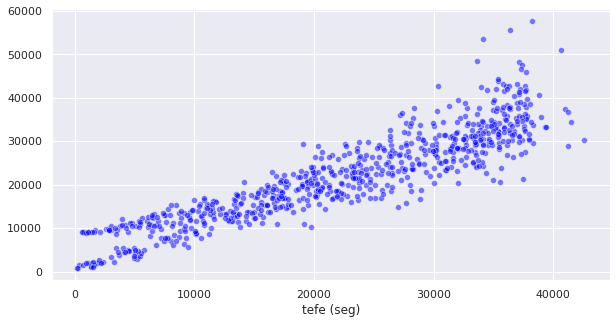

In [306]:
plt.figure(figsize=(10,5))
sns.scatterplot(y_test,y_pred,color='blue',alpha=0.5)

Residuales

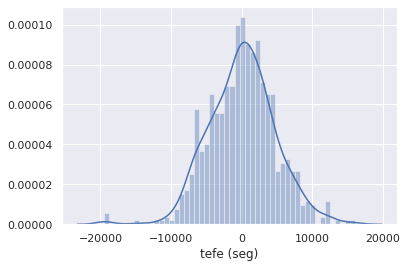

In [307]:
sns.distplot((y_test-y_pred),bins=50)

Error Cuadratico Medio

In [308]:
from sklearn import metrics
print(f'Error Cuadrático Medio: {metrics.mean_squared_error(y_test,y_pred)}')

Error Cuadrático Medio: 21934117.24607634


Se peude decir que la regresion lineal no en el mejor modelo para este tipo de data

#Regresión Logística

Generamos nuestro data de entrenamiento y le eliminamos las columnas que no ocuparemos en el modolamiento

In [398]:
filtro = ['Fecha','Equipo','Turno','Unidad organizativa','Posición','tefe (seg)','tdem (seg)','R-ef (t/h)','Mes','Dia','Año','Eficiencia']
train = df_.drop(filtro,axis=1)

In [399]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1825 entries, 0 to 3137
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Cargas (u)         1825 non-null   int64  
 1   Movimiento (t)     1825 non-null   float64
 2   Edad del empleado  1825 non-null   int64  
 3   Eficiencia (bin)   1825 non-null   int64  
dtypes: float64(1), int64(3)
memory usage: 151.3 KB


Creamos nuestras variables dummies

In [400]:
unidad = pd.get_dummies(df_['Unidad organizativa'])
posicion = pd.get_dummies(df_['Posición'])
turno = pd.get_dummies(df_['Turno'])
fecha = pd.get_dummies(df_['Fecha'])

**DUDA**

Agregamos las variables dummies a la data de entrenamiento

In [401]:
train = pd.concat([train,unidad,posicion,turno],axis=1)

In [402]:
train.head()

,Cargas (u),Movimiento (t),Edad del empleado,Eficiencia (bin),ADMINISTRACION SUPTCIA PLANTAS,ALJIBES MLC,CAMIONES CAT 793F MLC,CAMIONES KOMATSU 830E MLC,CARGADORES FRONTALES MLC,GEOLOGIA DE PRODUCCION,INGENIERIA DE PROCESOS,MANTENIMIENTO MINA,MOTONIVELADORAS MLC,PALAS HIDRAULICAS MLC,PLANIFICACION MANTTO. MINA,SERVICIO SOCIAL VHUASCO,SISTEMAS DE CONTROL Y POTENCIA,TRACTORES NEUMATICOS MLC,TRACTORES ORUGA MLC,ASISTENTE GEOLOGIA,AYUDANTE ADMINISTRATIVO,CONTROLADOR PLANIFICACION,ELECTRICO I,ELECTRICO III,INGENIERO DE PROCESOS,JEFE SISTEMAS DE CONTROL Y POTENCIA,MECANICO I,MECANICO III,OPERADOR ELECTRICO II PLANTA,OPERADOR I,OPERADOR II,OPERADOR III,OPERADOR MECANICO III PLANTA,PLANIFICADOR MANTENIMIENTO MINA,1,2
0,93,21134.20117,29,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
1,12,2833.59961,54,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
4,100,23335.70117,62,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
5,148,34061.60938,48,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
6,7,1632.20007,33,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0


Creamos nuestra data de entrenamiento y de test

In [403]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train.drop('Eficiencia (bin)',axis=1),train['Eficiencia (bin)'],test_size=0.30,random_state=42)

Importamos el modelo, creamos la regresión y entrenamos con nuestra data de entrenamiento

In [404]:
from sklearn.linear_model import LogisticRegression
modelo = LogisticRegression()
modelo.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Predicción con la data de test

In [405]:
y_pred = modelo.predict(X_test)

Evaluacion del modelo

In [406]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.81      0.77      0.79       261
           1       0.80      0.84      0.82       287

    accuracy                           0.81       548
   macro avg       0.81      0.81      0.81       548
weighted avg       0.81      0.81      0.81       548



In [407]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test,y_pred))

[[202  59]
 [ 47 240]]


#Decision Tree

In [408]:
from sklearn.tree import DecisionTreeClassifier

In [409]:
modelo = DecisionTreeClassifier()

In [410]:
modelo.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [411]:
y_pred = modelo.predict(X_test)

In [412]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.82      0.84      0.83       261
           1       0.85      0.84      0.84       287

    accuracy                           0.84       548
   macro avg       0.84      0.84      0.84       548
weighted avg       0.84      0.84      0.84       548



In [413]:
print(confusion_matrix(y_test,y_pred))

[[219  42]
 [ 47 240]]


#Random Forest

In [414]:
from sklearn.ensemble import RandomForestClassifier

In [415]:
modelo = RandomForestClassifier(n_estimators=100)

In [416]:
modelo.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [417]:
y_pred = modelo.predict(X_test)

In [418]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.85      0.85      0.85       261
           1       0.87      0.87      0.87       287

    accuracy                           0.86       548
   macro avg       0.86      0.86      0.86       548
weighted avg       0.86      0.86      0.86       548



In [419]:
print(confusion_matrix(y_test,y_pred))

[[223  38]
 [ 38 249]]


##Importancia de las variables

In [420]:
importancia = list(modelo.feature_importances_)

In [422]:
for i in range(len(importancia)):
  print(f'{i+1}.- Variable: {train.columns[i+1]} Importancia: {importancia[i]}')

1.- Variable: Movimiento (t) Importancia: 0.40801108705088307
2.- Variable: Edad del empleado Importancia: 0.4424077939436795
3.- Variable: Eficiencia (bin) Importancia: 0.051212800578259096
4.- Variable: ADMINISTRACION SUPTCIA PLANTAS Importancia: 0.0031791644476806815
5.- Variable: ALJIBES MLC Importancia: 0.0014625429163027729
6.- Variable: CAMIONES CAT 793F MLC Importancia: 0.0039411380275277555
7.- Variable: CAMIONES KOMATSU 830E MLC Importancia: 0.002242574081578229
8.- Variable: CARGADORES FRONTALES MLC Importancia: 0.0016838926316783142
9.- Variable: GEOLOGIA DE PRODUCCION Importancia: 0.0018808751304829172
10.- Variable: INGENIERIA DE PROCESOS Importancia: 0.0015360740835802364
11.- Variable: MANTENIMIENTO MINA Importancia: 0.0036340679636441852
12.- Variable: MOTONIVELADORAS MLC Importancia: 0.004323253952847291
13.- Variable: PALAS HIDRAULICAS MLC Importancia: 0.0012248866229973236
14.- Variable: PLANIFICACION MANTTO. MINA Importancia: 0.0013191936263015078
15.- Variable: SE